# Capstone: NFTs
## Part V: Price Predictor Model

### 1. Import Libraries

In [720]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

# SKlearn imports:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNetCV, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.ensemble import VotingRegressor, BaggingClassifier, BaggingRegressor, RandomForestClassifier, RandomForestRegressor, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostRegressor, AdaBoostClassifier, GradientBoostingRegressor, GradientBoostingClassifier, HistGradientBoostingClassifier, HistGradientBoostingRegressor 
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn import set_config
from sklearn.feature_selection import RFE, SelectKBest, f_regression

# tensorflow/neural networks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

### 2. Read In & Inspect Data

In [1165]:
trans = pd.read_csv('../data/clean_transactions.csv')
indiv = pd.read_csv('../data/extra_clean_individual.csv')
rarity = pd.read_csv('../data/clean_rarity.csv')

In [3]:
trans.head()

,usd,date,trans,punk_id,accessories,type
0,401.264,2021-08-30,Sold,9001,"['Clown Nose', 'Bandana', 'Nerd Glasses']",female
1,383.662,2021-08-30,Sold,9001,"['Clown Nose', 'Bandana', 'Nerd Glasses']",female
2,19.230,2021-02-17,Sold,9001,"['Clown Nose', 'Bandana', 'Nerd Glasses']",female
3,2.085,2020-10-03,Sold,9001,"['Clown Nose', 'Bandana', 'Nerd Glasses']",female
4,0.085,2019-05-06,Sold,9001,"['Clown Nose', 'Bandana', 'Nerd Glasses']",female


In [4]:
indiv.head()

,punk_id,type,accessories,3d glasses,bandana,beanie,big beard,big shades,black lipstick,blonde bob,...,avg_usd_offer,max_usd_offer,total_transfers,recent_usd_sale,rarity_score,avg_usd_bid_neigh,max_usd_bid_neigh,avg_usd_offer_neigh,max_usd_offer_neigh,avg_usd_sale_type
0,0,female,"['Green Eye Shadow', 'Earring', 'Blonde Bob']",0,0,0,0,0,0,1,...,NaN,NaN,0.0,NaN,114.832417,1029.904667,1140.0000,0.000000,0.000000,478.063621
1,1,male,"['Smile', 'Mohawk']",0,0,0,0,0,0,0,...,NaN,NaN,0.0,NaN,70.169684,449.666000,742.6520,148.870668,354.665333,226.479061
2,2,female,['Wild Hair'],0,0,0,0,0,0,0,...,NaN,NaN,1.0,NaN,56.017810,61.223000,149.4330,561.615000,561.615000,478.063621
3,3,male,"['Wild Hair', 'Nerd Glasses', 'Pipe']",0,0,0,0,0,0,0,...,NaN,NaN,0.0,NaN,76.289503,95.708000,95.7080,370.963021,774.088000,226.479061
4,4,male,"['Big Shades', 'Wild Hair', 'Earring', 'Goat']",0,0,0,0,1,0,0,...,NaN,NaN,0.0,NaN,88.738357,95.418583,95.7945,128.835794,288.759667,226.479061


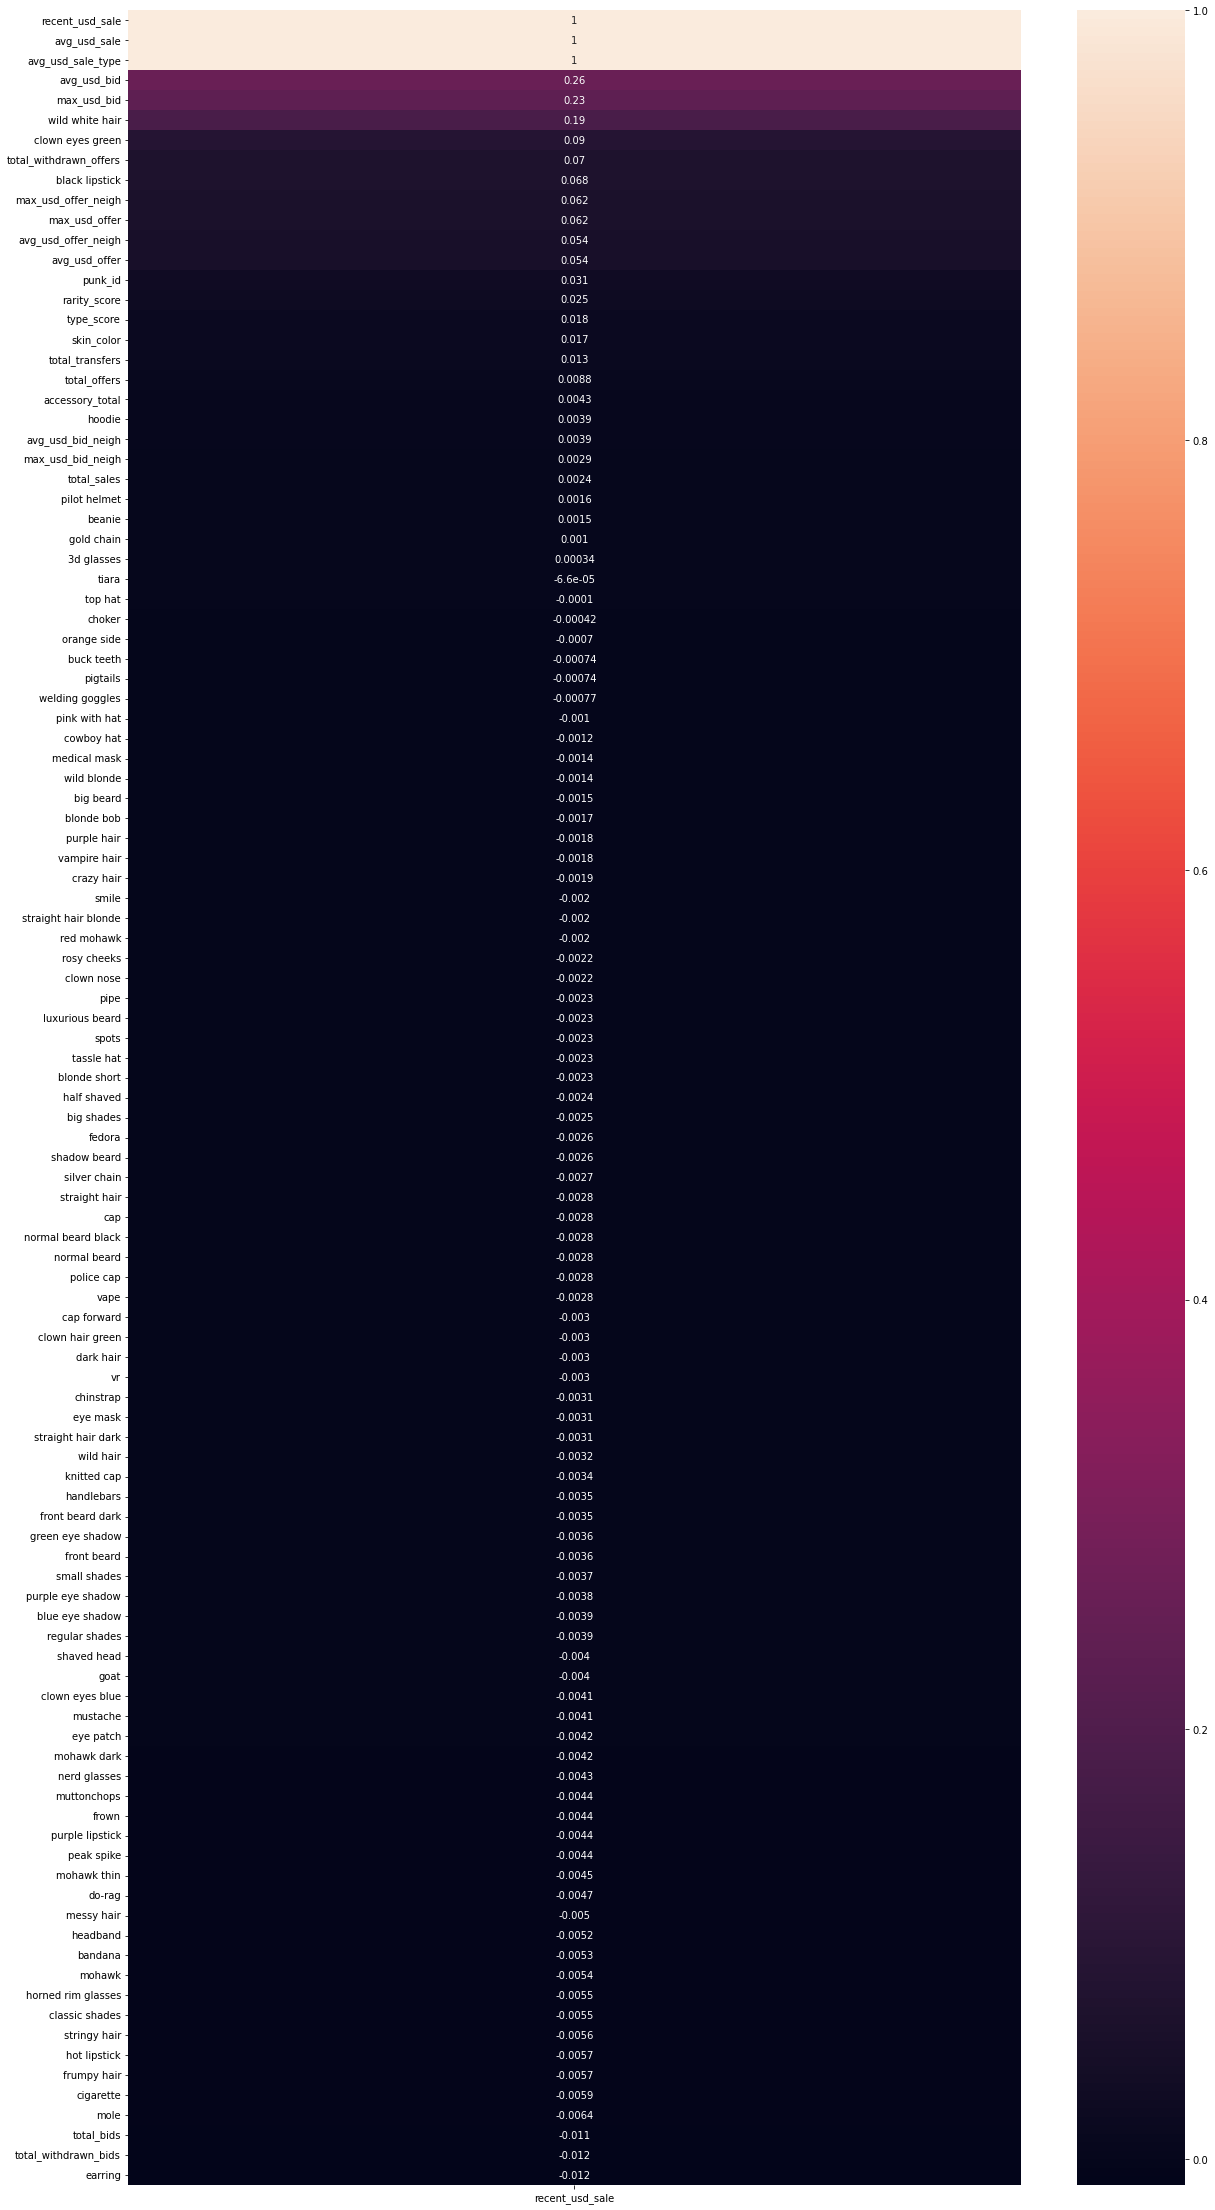

In [882]:
plt.figure(figsize=(20,40))
sns.heatmap(indiv.corr()[['recent_usd_sale']].sort_values(by='recent_usd_sale', ascending=False), annot=True);

### 3. Set Up & Baseline

The estimated value of the punk is the price the punk last sold for. I want to create a model that will predict the estimated value of all the Punks, regardless of how much transaction data is around it. In order to do this, I will train the model on data from punks that do have a recent sale:

In [1166]:
indiv.shape

(10000, 110)

In [1167]:
indiv.dropna(subset = ["recent_usd_sale"], inplace=True)

In [1168]:
indiv.shape

(3052, 110)

Because Type Plays such a large role in the price, I will add this column (from rarity) and add it to the individual dataset:

In [1169]:
indiv['type_score'] = rarity['type']

### 4. Neural Networks Models

**Model 1**

Let's use all the numeric columns of the individual dataset, with the exception of the old averages and old max columns that have empty values (we will use the averages neighbors/type and max neighbors instead because these don't have empty values).

In [1170]:
X = indiv.select_dtypes(include=np.number).drop(columns = {'recent_usd_sale', 'avg_usd_sale', 'avg_usd_bid', 'max_usd_bid', 'avg_usd_offer', 'max_usd_offer'})

In [1171]:
X.shape

(3052, 102)

In [1172]:
y = indiv['recent_usd_sale']

In [1176]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

Let's see the baseline before creating neural networks model:

In [1174]:
y_baseline = np.full_like(y_test, y_test.mean())
y_baseline

array([276.47650329, 276.47650329, 276.47650329, 276.47650329,
       276.47650329, 276.47650329, 276.47650329, 276.47650329,
       276.47650329, 276.47650329, 276.47650329, 276.47650329,
       276.47650329, 276.47650329, 276.47650329, 276.47650329,
       276.47650329, 276.47650329, 276.47650329, 276.47650329,
       276.47650329, 276.47650329, 276.47650329, 276.47650329,
       276.47650329, 276.47650329, 276.47650329, 276.47650329,
       276.47650329, 276.47650329, 276.47650329, 276.47650329,
       276.47650329, 276.47650329, 276.47650329, 276.47650329,
       276.47650329, 276.47650329, 276.47650329, 276.47650329,
       276.47650329, 276.47650329, 276.47650329, 276.47650329,
       276.47650329, 276.47650329, 276.47650329, 276.47650329,
       276.47650329, 276.47650329, 276.47650329, 276.47650329,
       276.47650329, 276.47650329, 276.47650329, 276.47650329,
       276.47650329, 276.47650329, 276.47650329, 276.47650329,
       276.47650329, 276.47650329, 276.47650329, 276.47

In [1180]:
rmse_null = mean_squared_error(y_test, y_baseline, squared = False)
rmse_null

223.89288887476022

Therefore, I will need to create models that beat this RMSE.

In [1092]:
model_2 = Sequential()

# input layer
model_2.add(Dense(103, activation = 'relu')) 

# hideen layer
model_2.add(Dense(12, activation = 'relu')) 
model_2.add(Dense(128, activation = 'relu')) 
model_2.add(Dense(128, activation = 'relu')) 
model_2.add(Dense(128, activation = 'relu')) 

# output layer
model_2.add(Dense(1)) 

In [1094]:
model_2.compile(optimizer = 'adam', loss = 'mse', metrics=['mse'])

In [1095]:
history_2 = model_2.fit(
    X_train, 
    y_train, 
    batch_size = 128, 
    epochs = 2000,
    verbose = 1,
    validation_split = .2
)

Epoch 1/2000
15/15 [==============================] - 0s 9ms/step - loss: 192006.9531 - mse: 192006.9531 - val_loss: 593983680.0000 - val_mse: 593983680.0000
Epoch 2/2000
15/15 [==============================] - 0s 3ms/step - loss: 151949.3594 - mse: 151949.3594 - val_loss: 561987904.0000 - val_mse: 561987904.0000
Epoch 3/2000
15/15 [==============================] - 0s 3ms/step - loss: 105265.0859 - mse: 105265.0859 - val_loss: 550009920.0000 - val_mse: 550009920.0000
Epoch 4/2000
15/15 [==============================] - 0s 2ms/step - loss: 72338.8516 - mse: 72338.8516 - val_loss: 461464672.0000 - val_mse: 461464672.0000
Epoch 5/2000
15/15 [==============================] - 0s 2ms/step - loss: 140982.5781 - mse: 140982.5781 - val_loss: 612560960.0000 - val_mse: 612560960.0000
Epoch 6/2000
15/15 [==============================] - 0s 2ms/step - loss: 70262.4062 - mse: 70262.4062 - val_loss: 471625920.0000 - val_mse: 471625920.0000
Epoch 7/2000
15/15 [==============================] - 0s

In [1096]:
model_2.evaluate(X_test, y_test) 

24/24 [==============================] - 0s 550us/step - loss: 4812.8618 - mse: 4812.8618


[4812.86181640625, 4812.86181640625]

In [1044]:
X_test.shape

(763, 103)

In [1097]:
preds_2 = model_2.predict(X_test)

In [1098]:
X_test['preds_2'] = preds_2

In [1099]:
X_test[['preds_2']].tail(15)

,preds_2
5196,348.669189
4639,300.638123
3759,222.021515
7726,114.685226
6406,242.717041
7456,392.651703
5847,106.928123
5681,185.541336
4515,391.914551
8924,181.049210


In [1100]:
mean_squared_error(y_test, preds_2, squared = False)

69.3747956596254

In [936]:
# ss: 4494.6616 - mse: 4494.6616
# 67.04223715585198

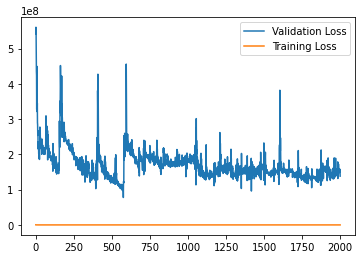

In [934]:
plt.plot(history_2.history['val_loss'], label='Validation Loss')
plt.plot(history_2.history['loss'], label='Training Loss')
plt.legend();

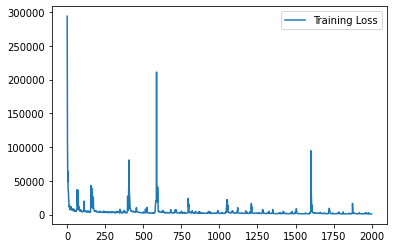

In [935]:
plt.plot(history_2.history['loss'], label='Training Loss')
plt.legend();

**Model 2**

I will attempt to use fewer columns than the previous model:

In [883]:
X = indiv[['avg_usd_sale_type',
           'max_usd_bid_neigh',
            'type_score']]
y = indiv['recent_usd_sale']

In [884]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

In [893]:
model_3 = Sequential()

# input layer
model_3.add(Dense(3, activation = 'relu')) 

# hideen layer
model_3.add(Dense(12, activation = 'relu')) 
model_3.add(Dense(128, activation = 'relu')) 

# output layer
model_3.add(Dense(1)) 

In [894]:
model_3.compile(optimizer = 'adam', loss = 'mse', metrics=['mse'])

In [895]:
history_3 = model_3.fit(
    X_train, 
    y_train, 
    batch_size = 128, 
    epochs = 2000,
    verbose = 1,
    validation_split = .2
)

Epoch 1/2000
15/15 [==============================] - 0s 8ms/step - loss: 240571.8750 - mse: 240571.8750 - val_loss: 554345664.0000 - val_mse: 554345728.0000
Epoch 2/2000
15/15 [==============================] - 0s 2ms/step - loss: 150394.7344 - mse: 150394.7344 - val_loss: 438560576.0000 - val_mse: 438560576.0000
Epoch 3/2000
15/15 [==============================] - 0s 2ms/step - loss: 87769.3125 - mse: 87769.3125 - val_loss: 326955168.0000 - val_mse: 326955168.0000
Epoch 4/2000
15/15 [==============================] - 0s 2ms/step - loss: 46759.7578 - mse: 46759.7578 - val_loss: 251802848.0000 - val_mse: 251802832.0000
Epoch 5/2000
15/15 [==============================] - 0s 2ms/step - loss: 26490.3379 - mse: 26490.3379 - val_loss: 201712832.0000 - val_mse: 201712832.0000
Epoch 6/2000
15/15 [==============================] - 0s 2ms/step - loss: 15603.0615 - mse: 15603.0615 - val_loss: 169194592.0000 - val_mse: 169194592.0000
Epoch 7/2000
15/15 [==============================] - 0s 2ms

In [888]:
model_3.evaluate(X_test, y_test) 

24/24 [==============================] - 0s 498us/step - loss: 11670.0293 - mse: 11670.0293


[11670.029296875, 11670.029296875]

In [896]:
preds_3 = model_3.predict(X_test)

In [897]:
#X_test['preds_3'] = preds_3

In [898]:
#X_test[['preds_3']].tail(15)

In [899]:
mean_squared_error(y_test, preds_3, squared= False)

76.3324496774523

### 5. Other Models

In [1046]:
X = indiv[['avg_usd_sale_type',
           'max_usd_bid_neigh',
            'type_score']]
y = indiv['recent_usd_sale']

In [1047]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=123)

**Test Models**

In [1006]:
def model_score(model):
    # create pipeline and score
    pipe = make_pipeline(PolynomialFeatures(), StandardScaler(), model)
    pipe.fit(X_train, y_train)
    score = pipe.score(X_test, y_test)
    
    # create predictions for MSE
    preds = pipe.predict(X_test)
    RMSE = mean_squared_error(y_test, preds,  squared=False)
    
    # print results
    print(model)
    print(f'The score of this model is: {score}')
    return(f'The RMSE of this model is: {RMSE}')

In [1007]:
lr = LinearRegression()
rr = Ridge(random_state=123)
las = Lasso(random_state=123)
ela = ElasticNet(random_state = 123)
knn = KNeighborsRegressor()
dtr = DecisionTreeRegressor(random_state=123)
bag = BaggingRegressor(random_state=123)
rfr = RandomForestRegressor(random_state=123)
ada = AdaBoostRegressor(random_state=123)
gb = GradientBoostingRegressor(random_state = 123)

In [1008]:
models = [lr, rr, las, ela, knn, dtr, bag, rfr, ada, gb]

In [1009]:
for model in models:
    print(model_score(model))

LinearRegression()
The score of this model is: 0.8705783247761347
The RMSE of this model is: 83.0856241344864
Ridge(random_state=123)
The score of this model is: 0.8695490563185153
The RMSE of this model is: 83.41535274628578
Lasso(random_state=123)
The score of this model is: 0.8155591847053623
The RMSE of this model is: 99.18611841453247
ElasticNet(random_state=123)
The score of this model is: 0.2817663630756946
The RMSE of this model is: 195.72903205101562
KNeighborsRegressor()
The score of this model is: 0.8205847616916008
The RMSE of this model is: 97.82549210226365
DecisionTreeRegressor(random_state=123)
The score of this model is: 0.7652136076340187
The RMSE of this model is: 111.90740870259428
BaggingRegressor(random_state=123)
The score of this model is: 0.8559330945882848
The RMSE of this model is: 87.66061069525998


/Users/olivialara/opt/anaconda3/envs/nlp/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.715e+07, tolerance: 2.833e+07
  model = cd_fast.enet_coordinate_descent(


RandomForestRegressor(random_state=123)
The score of this model is: 0.8675928286932042
The RMSE of this model is: 84.03846900040848
AdaBoostRegressor(random_state=123)
The score of this model is: 0.7173330703009297
The RMSE of this model is: 122.78911775293544
GradientBoostingRegressor(random_state=123)
The score of this model is: 0.879216148046613
The RMSE of this model is: 80.26511198724216


**Gradient Boosting Regressor**

In [1010]:
pipe = make_pipeline(PolynomialFeatures(), StandardScaler(), gb)

In [1011]:
pipe.get_params()
#gs.get_params()

{'memory': None,
 'steps': [('polynomialfeatures', PolynomialFeatures()),
  ('standardscaler', StandardScaler()),
  ('gradientboostingregressor', GradientBoostingRegressor(random_state=123))],
 'verbose': False,
 'polynomialfeatures': PolynomialFeatures(),
 'standardscaler': StandardScaler(),
 'gradientboostingregressor': GradientBoostingRegressor(random_state=123),
 'polynomialfeatures__degree': 2,
 'polynomialfeatures__include_bias': True,
 'polynomialfeatures__interaction_only': False,
 'polynomialfeatures__order': 'C',
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'gradientboostingregressor__alpha': 0.9,
 'gradientboostingregressor__ccp_alpha': 0.0,
 'gradientboostingregressor__criterion': 'friedman_mse',
 'gradientboostingregressor__init': None,
 'gradientboostingregressor__learning_rate': 0.1,
 'gradientboostingregressor__loss': 'squared_error',
 'gradientboostingregressor__max_depth': 3,
 'gradientboostingregressor__max_fe

In [1012]:
params = {
    'gradientboostingregressor__alpha' : [0.01, 0.1, .9], # tried: 0.9
    #'polynomialfeatures__degree': [2], # tried: 2, 10
    #'polynomialfeatures__include_bias': [True, False],
    #'gradientboostingregressor__max_features': [None, 2],
    #'gradientboostingregressor__n_estimators': [10, 100, 1000]
}

In [1013]:
gs = GridSearchCV(pipe, params, n_jobs=-1)
gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('standardscaler', StandardScaler()),
                                       ('gradientboostingregressor',
                                        GradientBoostingRegressor(random_state=123))]),
             n_jobs=-1,
             param_grid={'gradientboostingregressor__alpha': [0.01, 0.1, 0.9]})

In [1014]:
gs.best_estimator_.named_steps

{'polynomialfeatures': PolynomialFeatures(),
 'standardscaler': StandardScaler(),
 'gradientboostingregressor': GradientBoostingRegressor(alpha=0.01, random_state=123)}

In [1015]:
gs.best_params_

{'gradientboostingregressor__alpha': 0.01}

In [1016]:
gs.score(X_test, y_test)

0.879216148046613

In [1017]:
gb_preds = gs.predict(X_test)

In [1019]:
mean_squared_error(y_test, gb_preds,  squared=False)

80.26511198724216

In [992]:
gb_preds

array([ 197.3958284 ,  216.53011902,  419.28632036,   73.72306911,
         69.04940424,  225.08275581,   62.65014272,  422.24709749,
        438.57902259,   63.16617264,   63.24010009,  415.97109657,
         70.63906565,  195.4142539 ,  146.38689384,   66.55289322,
         46.93796361,  276.9609675 ,  406.4874704 ,  535.61092905,
        434.17418525,  298.3218202 ,  102.35543048,  805.37315603,
         58.99069444,  372.78618274,  173.18490907,  455.84426755,
         74.13622945,   64.55223946,  423.422265  ,  445.92663928,
        472.79479836,  101.85559572,  304.1940826 ,  291.93443235,
         81.63623946,  106.40991996,  339.81813324,  102.35543048,
        382.19926296,  142.03210354,  581.71967103,  468.99828259,
        244.1546753 ,  173.18490907,  317.12436356,  197.3958284 ,
        197.3958284 ,  279.42031787,   53.39341253,  414.18809396,
        434.17418525,   78.69055369,  206.38277337,  405.92351345,
         98.52640373,   83.1028328 ,  291.93443235,   45.74705

In [993]:
X_test['gb_preds'] = gb_preds

In [994]:
X_test

,avg_usd_sale_type,max_usd_bid_neigh,type_score,gb_preds
4142,159.813500,169.8010,1.655903,197.395828
2723,165.772000,112.2840,2.604167,216.530119
8236,394.066000,175.5724,1.655903,419.286320
3910,61.824000,51.8000,1.655903,73.723069
7505,69.535600,155.2780,1.655903,69.049404
...,...,...,...,...
328,138.785000,141.7520,1.655903,174.187526
8294,97.466000,102.4280,1.655903,119.621280
8051,244.119500,161.9790,1.655903,330.279093
8740,55.446000,59.1580,1.655903,68.605761


### 6. Save Gradient Boosting and Neural Networks Predictions for Website

Reload individual dataset, as we dropped punks that didn't have recent sale data earlier:

In [1057]:
indiv = pd.read_csv('../data/extra_clean_individual.csv')

Add type score to individual dataset, as we have earlier:

In [1058]:
indiv['type_score'] = rarity['type']

Use ALL punks instead of ones that just have recent sale data:

In [1059]:
X_all = indiv[['avg_usd_sale_type',
           'max_usd_bid_neigh',
            'type_score']]

In [1060]:
gb_preds_all = gs.predict(X_all)

In [1061]:
X_all['gb_preds_all'] = gb_preds_all

/var/folders/j5/_vk8rntd5blc5cd__7h03h0c0000gn/T/ipykernel_7773/3262848971.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_all['gb_preds_all'] = gb_preds_all


In [1064]:
X_all.head(10)

,avg_usd_sale_type,max_usd_bid_neigh,type_score,gb_preds_all
0,478.063621,1140.0000,2.604167,549.214923
1,226.479061,742.6520,1.655903,371.633313
2,478.063621,149.4330,2.604167,496.004744
3,226.479061,95.7080,1.655903,302.202359
4,226.479061,95.7945,1.655903,302.202359
5,478.063621,16.0980,2.604167,490.221864
6,226.479061,3.9230,1.655903,308.408061
7,478.063621,4.4850,2.604167,489.316588
8,226.479061,300.0915,1.655903,309.382012
9,226.479061,56.7000,1.655903,317.409505


In [1066]:
X_all.sort_values(by='gb_preds_all').tail(20)

,avg_usd_sale_type,max_usd_bid_neigh,type_score,gb_preds_all
2924,4605.0000,2410.000000,416.666667,5264.542808
6145,4605.0000,2350.000000,416.666667,5264.542808
4178,4605.0000,466.005000,416.666667,5282.177718
372,4605.0000,2070.000000,416.666667,5286.676188
5217,5450.0000,2930.000000,416.666667,5426.570103
2243,4605.0000,6430.000000,416.666667,5427.438156
5795,4605.0000,6560.000000,416.666667,5427.438156
6965,4605.0000,7060.000000,416.666667,5690.372126
5314,4605.0000,7950.000000,416.666667,5690.372126
2890,7575.0000,87640.000000,1111.111111,6573.555962


In [1122]:
X_all.to_csv('../data/gb_preds.csv')

In [1104]:
# save nn preds

In [1110]:
indiv = pd.read_csv('../data/extra_clean_individual.csv')

In [1111]:
indiv['type_score'] = rarity['type']

In [1112]:
X_all_2 = X = indiv.select_dtypes(include=np.number).drop(columns = {'recent_usd_sale', 'avg_usd_sale', 'avg_usd_bid', 'max_usd_bid', 'avg_usd_offer', 'max_usd_offer'})

In [1113]:
nn_preds_all = model_2.predict(X_all_2)

In [1114]:
X_all_2['nn_preds_all'] = nn_preds_all

In [1115]:
X_all_2.sort_values(by='nn_preds_all').tail(20)

,punk_id,3d glasses,bandana,beanie,big beard,big shades,black lipstick,blonde bob,blonde short,blue eye shadow,...,total_withdrawn_offers,total_transfers,rarity_score,avg_usd_bid_neigh,max_usd_bid_neigh,avg_usd_offer_neigh,max_usd_offer_neigh,avg_usd_sale_type,type_score,nn_preds_all
2338,2338,0,0,0,0,0,0,0,0,0,...,0.0,0.0,279.978494,0.411000,0.411000,4150.000000,4.150000e+03,4320.0000,113.636364,4335.662109
5795,5795,0,0,0,0,0,0,0,0,0,...,1.0,1.0,912.624447,2186.907333,6560.000000,3200.000000,3.200000e+03,4605.0000,416.666667,4378.341797
2243,2243,0,1,0,0,0,0,0,0,0,...,0.0,1.0,874.414860,2790.144400,6430.000000,12392.857143,2.258000e+04,4605.0000,416.666667,4426.065918
2460,2460,0,1,0,0,0,0,0,0,0,...,0.0,0.0,887.052825,0.311000,0.311000,7796.428571,1.289000e+04,4605.0000,416.666667,4585.122559
2924,2924,0,0,0,0,0,0,0,0,0,...,0.0,0.0,901.973402,1222.612400,2410.000000,7796.428571,1.289000e+04,4605.0000,416.666667,4593.907715
2386,2386,0,0,0,0,0,0,0,0,0,...,0.0,0.0,887.227890,10.442500,20.574000,7120.952381,1.051667e+04,4605.0000,416.666667,4639.050781
6965,6965,0,0,0,0,0,0,0,0,0,...,6.0,1.0,917.126804,3093.075000,7060.000000,12392.857143,2.258000e+04,4605.0000,416.666667,4694.073730
9265,9265,0,1,0,0,1,0,0,0,0,...,0.0,1.0,875.623932,1336.836111,3020.000000,9081.428571,1.417500e+04,4605.0000,416.666667,4704.471191
5314,5314,0,0,0,0,0,0,0,0,0,...,0.0,0.0,888.167244,2308.144400,7950.000000,12392.857143,2.258000e+04,4605.0000,416.666667,4761.543945
4178,4178,0,0,0,0,0,0,0,0,0,...,0.0,0.0,896.696697,155.575667,466.005000,7796.428571,1.289000e+04,4605.0000,416.666667,4806.873535


In [1124]:
X_all_2[X_all_2['punk_id'] == 3100]

,punk_id,3d glasses,bandana,beanie,big beard,big shades,black lipstick,blonde bob,blonde short,blue eye shadow,...,total_withdrawn_offers,total_transfers,rarity_score,avg_usd_bid_neigh,max_usd_bid_neigh,avg_usd_offer_neigh,max_usd_offer_neigh,avg_usd_sale_type,type_score,nn_preds_all
3100,3100,0,0,0,0,0,0,0,0,0,...,0.0,0.0,2276.882794,12520.484001,87640.0,109283.333333,126190.0,7575.0,1111.111111,3863.818848


In [1126]:
X_all.iloc[3100]

avg_usd_sale_type     7575.000000
max_usd_bid_neigh    87640.000000
type_score            1111.111111
gb_preds_all          6573.555962
Name: 3100, dtype: float64

In [1128]:
X_all_2.rename(columns = {'nn_preds_all': 'nn_preds'}, inplace = True)

In [1139]:
X_all_2 = X_all_2[['punk_id','nn_preds']]

In [1142]:
def round_it(x):
    return(np.round(x, 2))

In [1143]:
round_it(9540.4903)

9540.49

In [1145]:
X_all_2['rounded_preds'] = X_all_2['nn_preds'].apply(round_it)

/var/folders/j5/_vk8rntd5blc5cd__7h03h0c0000gn/T/ipykernel_7773/981803905.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_all_2['rounded_preds'] = X_all_2['nn_preds'].apply(round_it)


In [1146]:
X_all_2

,punk_id,nn_preds,rounded_preds
0,0,407.429321,407.43
1,1,235.929596,235.93
2,2,459.713196,459.71
3,3,210.341873,210.34
4,4,215.630142,215.63
...,...,...,...
9995,9995,475.182922,475.18
9996,9996,212.467056,212.47
9997,9997,2314.197021,2314.20
9998,9998,311608.750000,311608.75


In [1147]:
X_all_2.to_csv('../data/nn_preds.csv', index = False)